In [1]:
import os
import pandas as pd
import numpy as np

from typing import Tuple

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from spacy import displacy

plt.style.use('ggplot')

In [2]:
DATASET_FOLDER = 'feedback-prize-2021'

def load_data_csv() -> pd.DataFrame:
    return pd.read_csv(
        os.path.join(DATASET_FOLDER, 'train.csv'), 
        dtype={'discourse_id': 'int64', 'discourse_start': int, 'discourse_end': int})

def load_file(file_id: str, folder: str = 'train') -> str:
    path = os.path.join(DATASET_FOLDER, folder, file_id + '.txt')
    with open(path, 'r') as f:
        text = f.read()
    return text

def load_texts(folder: str = 'train') -> pd.Series:
    data_path = os.path.join(DATASET_FOLDER, folder)

    def read(filename):
        with open(os.path.join(data_path, filename), 'r') as f:
            text = f.read()
        return text

    return pd.Series({fname.replace('.txt', ''): read(fname) for fname in tqdm(os.listdir(data_path))})     

def load_dataset() -> Tuple[pd.Series, pd.DataFrame]:
    return load_texts(), load_data_csv()

In [3]:
# Credits for this part of visualisation _> https://www.kaggle.com/thedrcat

DISCOURSE_TYPES_COLORS = {
    'Lead': '#8000ff',
    'Position': '#2b7ff6',
    'Evidence': '#2adddd',
    'Claim': '#80ffb4',
    'Concluding Statement': 'd4dd80',
    'Counterclaim': '#ff8042',
    'Rebuttal': '#ff0000'
}

def highlight_segments(id_example, texts, data):         
    ents = []
    for _, row in data[data['id'] == id_example].iterrows():
        ents.append({
            'start': int(row['discourse_start']), 
            'end': int(row['discourse_end']), 
            'label': row['discourse_type']
            })
    doc2 = {'text': texts[id_example], 'ents': ents, 'title': id_example}
    options = {'ents': data.discourse_type.unique().tolist(), 'colors': DISCOURSE_TYPES_COLORS}
    displacy.render(doc2, style='ent', options=options, manual=True, jupyter=True)

In [4]:
train_texts, train_data = load_dataset()

100%|██████████| 15594/15594 [00:01<00:00, 12314.53it/s]


In [5]:
test_texts = load_texts('test')

100%|██████████| 5/5 [00:00<?, ?it/s]


In [6]:
train_data.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


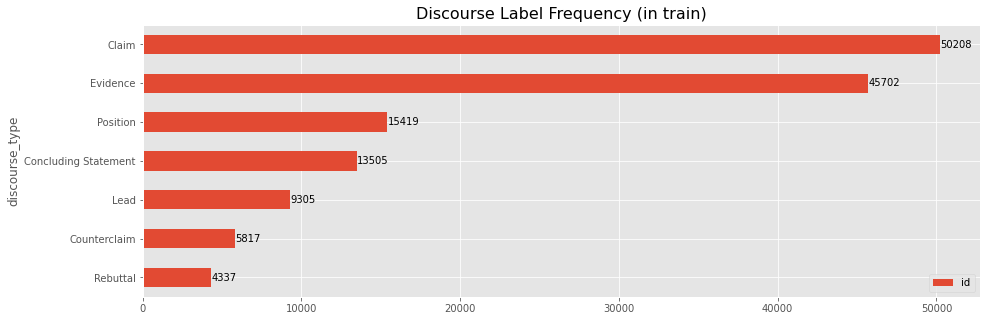

In [7]:
# Most annotation used:

ax = (
    train_data.groupby(by='discourse_type')[['id']]
    .count()
    .sort_values('id')
    .plot(kind="barh", figsize=(15, 5))
)
ax.set_title("Discourse Label Frequency (in train)", fontsize=16)
ax.bar_label(ax.containers[0], label_type="edge")
plt.show()

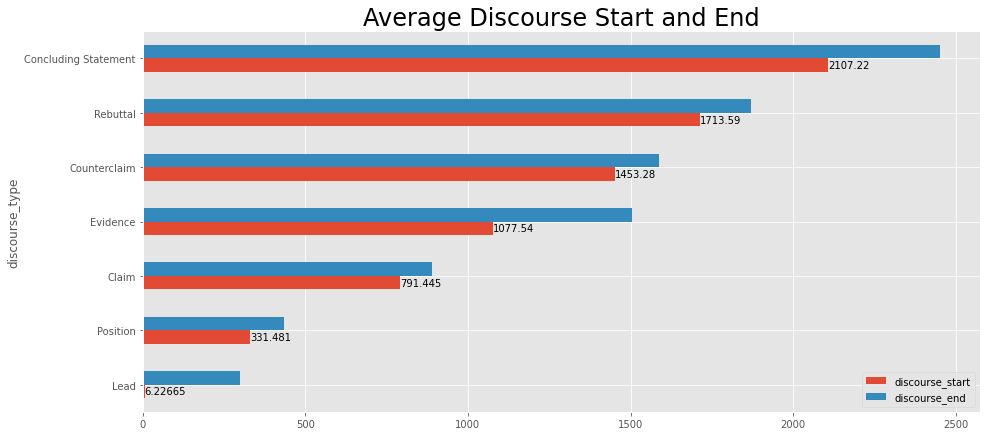

In [8]:
ax = (
    train_data.groupby("discourse_type")[["discourse_start", "discourse_end"]]
    .mean()
    .sort_values("discourse_start")
    .plot(kind="barh", figsize=(15, 7))
)
ax.set_title("Average Discourse Start and End", fontsize=24)
ax.bar_label(ax.containers[0], label_type="edge")
plt.show()

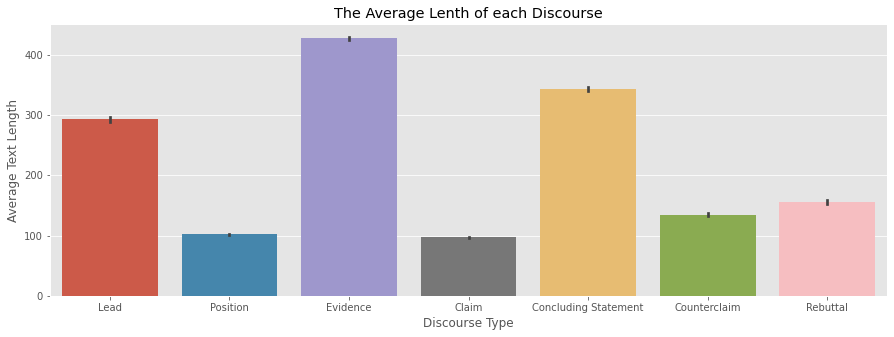

In [9]:
# The length of each label
train_data["discourse_len"] = (train_data["discourse_end"] - train_data["discourse_start"]).astype(
    "int"
)

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="discourse_type", y="discourse_len", data=train_data)
ax.set_title("The Average Lenth of each Discourse")
ax.set_xlabel("Discourse Type")
ax.set_ylabel("Average Text Length")
plt.show()

15594it [00:00, 35346.94it/s]


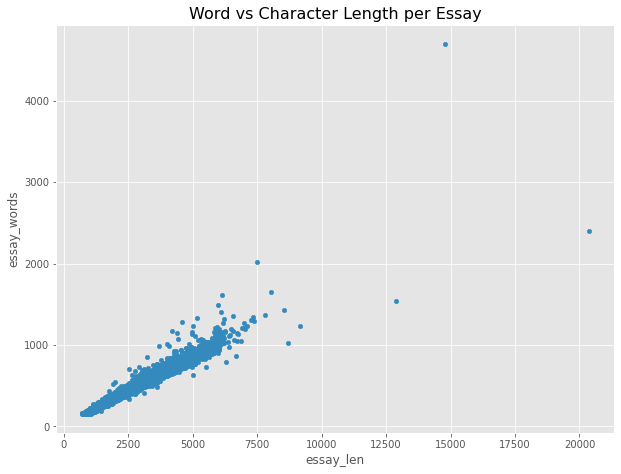

In [10]:
tmp = train_data.copy()

len_dict = {}
word_dict = {}
for myid, data in tqdm(train_texts.items()):
    mylen = len(data.strip())
    myword = len(data.split())
    len_dict[myid] = mylen
    word_dict[myid] = myword
tmp["essay_len"] = tmp["id"].map(len_dict)
tmp["essay_words"] = tmp["id"].map(word_dict)

fig, ax = plt.subplots(figsize=(10, 7.5))
tmp.groupby("id").first().plot(
    x="essay_len", y="essay_words", kind="scatter", ax=ax
)
ax.set_title("Word vs Character Length per Essay", fontsize=16)
plt.show()

In [11]:
ids_with_parts_no_label = []

for group_id, group in train_data.groupby(by='id'):
    init = -1
    for _, row in group.iterrows():
        g_init = row.discourse_start
        if g_init > init + 1:
            part = train_texts[group_id][init: g_init]
            if len(part) > 500: # keep only that ones with large parts without label
                ids_with_parts_no_label.append(group_id)
                break
        init = row.discourse_end
    if len(ids_with_parts_no_label) > 5: # only the firsts
        break
    

In [12]:
# examples = data['id'].sample(n=1, random_state=42).values.tolist()
examples = ids_with_parts_no_label
for ex in examples:
    highlight_segments(ex, train_texts, train_data)
    print('\n')

In [13]:
def text_to_color(essay, discourse_type, predictionstring):
    """
    Takes an entire essay, the discourse type and prediction string.
    Returns highlighted text for the prediction string
    """
    discourse_color_map = {
        "Lead": 1,  # 1 red
        "Position": 2,  # 2 green
        "Evidence": 3,  # 3 yellow
        "Claim": 4,  # 4 blue
        "Concluding Statement": 5,  # 5 magenta
        "Counterclaim": 6,  # 6 cyan
        "Rebuttal": 7,  # 7 white
        "None": 9,  # default
    }
    hcolor = discourse_color_map[discourse_type]
    text_index = [int(c) for c in predictionstring.split()]
    text_subset = " ".join(np.array(essay.split())[text_index])
    if discourse_type == "None":
        return f"\033[4{hcolor};30m{text_subset}\033[m"
    return f"\033[4{hcolor};30m{text_subset}\033[m"


def get_non_discourse_df(train, essay, id):
    all_pred_strings = " ".join(train.query("id == @id")["predictionstring"].values)
    all_pred_strings = [int(c) for c in all_pred_strings.split()]
    # [c for c in all_pred_strings

    non_discourse_df = pd.DataFrame(
        [c for c in range(len(essay.split())) if c not in all_pred_strings]
    )
    non_discourse_df.columns = ["predictionstring"]
    non_discourse_df["cluster"] = (
        non_discourse_df["predictionstring"].diff().fillna(1) > 1
    ).cumsum()

    non_discourse_strings = []
    for i, d in non_discourse_df.groupby("cluster"):
        pred_string = [str(x) for x in d["predictionstring"].values]
        non_discourse_strings.append(" ".join(pred_string))
    df = pd.DataFrame(non_discourse_strings).rename(columns={0: "predictionstring"})
    df["discourse_type"] = "None"
    return df


def get_colored_essay(train, id):
    essay = train_texts[id]
    all_text = ""
    train_subset = train.query("id == @id").copy()
    df = get_non_discourse_df(train, essay, id)
    train_subset = pd.concat([train_subset, df])
    train_subset["first_index"] = (
        train_subset["predictionstring"].str.split(" ").str[0].astype("int")
    )
    train_subset = train_subset.sort_values("first_index").reset_index(drop=True).copy()
    for i, d in train_subset.iterrows():
        colored_text = text_to_color(essay, d.discourse_type, d.predictionstring)
        all_text += " " + colored_text
    return all_text[1:]


all_text = get_colored_essay(train_data, "423A1CA112E2")
print(all_text)

Phones Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it. When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation. Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. Some